# Training the machine learning model

In this notebook we're going to create a machine learning model and train it against the features that we engineered in the previous notebook.

We’ll be using a random forest classifier. This method is well suited as our data set will be comprised of a mix of strong and weak features. While the weak features will sometimes be helpful, the random forest method will ensure we don’t create a model that only fits our training data.

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# tag::imports[]
from sklearn.ensemble import RandomForestClassifier
# end::imports[]

Let's first load the features that we engineered in the previous notebook:

In [2]:
# Load the CSV files saved in the train/test notebook

df_train_under = pd.read_csv("data/df_train_under_all.csv")
df_test_under = pd.read_csv("data/df_test_under_all.csv")

In [5]:
df_train_under.sample(5)

,cn,maxCoefficient,maxTriangles,minCoefficient,minTriangles,node1,node2,pa,sl,sp,tn,label
91068,14.000,1.000,105,1.000,105,35478,35488,225.000,1.000,1.000,16.000,1
12719,0.000,0.462,42,0.309,17,156289,156697,154.000,0.000,0.000,25.000,0
18901,0.000,0.833,6,0.400,5,71703,242410,24.000,0.000,1.000,10.000,0
69066,0.000,1.000,18,0.105,10,28646,214195,95.000,0.000,0.000,24.000,0
91996,2.000,1.000,3,1.000,3,36192,36193,9.000,1.000,1.000,4.000,1


In [6]:
df_test_under.sample(5)

,cn,maxCoefficient,maxTriangles,minCoefficient,minTriangles,node1,node2,pa,sl,sp,tn,label
90138,5.000,1.000,15,1.000,15,107171,107173,36.000,1.000,1.000,7.000,1
128932,1.000,1.000,4,0.267,1,113249,231845,32.000,1.000,1.000,17.000,1
123545,1.000,0.667,10,0.000,0,83693,217940,36.000,0.000,1.000,14.000,1
74703,3.000,1.000,14,0.133,3,1849,1851,323.000,0.000,1.000,33.000,1
116934,2.000,0.547,238,0.400,4,97038,196093,200.000,0.000,1.000,43.000,1


## Model Selection


Now that we’ve generated all our features, it’s time to create our classifier. We’re going to create a random forest.

This method is well suited as our data set will be comprised of a mix of strong and weak features. While the weak features will sometimes be helpful, the random forest method will ensure we don’t create a model that over fits our training data.

We can create our random forest classifier with the following code:

In [7]:
# tag::create-classifier[]
classifier = RandomForestClassifier(n_estimators=30, max_depth=10, random_state=0)
# end::create-classifier[]

And now let's train the model:

In [8]:
# tag::train-model[]
columns = [
    "cn", "pa", "tn", # graph features
    "minTriangles", "maxTriangles", "minCoefficient", "maxCoefficient", # triangle features  
    "sp", "sl" # community features
]

X = df_train_under[columns]
y = df_train_under["label"]
classifier.fit(X, y)
# end::train-model[]

RandomForestClassifier(max_depth=10, n_estimators=30, random_state=0)

## Model Evaluation
We’re going to evaluate the quality of our model by computing its accuracy, precision, and recall. The diagram below, taken from the O’Reilly Graph Algorithms Book, explains how each of these metrics are computed.

<img src="https://neo4j.com/developer/graph-data-science/_images/model-evaluation.png" width="800" height="400">



Next we're going to evaluate our model and see which features are the most influential. The following two functions will help us do this:

In [9]:
# tag::evaluation-imports[]
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
# end::evaluation-imports[]

# tag::evaluation-functions[]
def evaluate_model(predictions, actual):
    return pd.DataFrame({
        "Measure": ["Accuracy", "Precision", "Recall"],
        "Score": [accuracy_score(actual, predictions), 
                  precision_score(actual, predictions), 
                  recall_score(actual, predictions)]
    })
# end::evaluation-functions[]

def feature_importance(columns, classifier):        
    display("Feature Importance")
    df = pd.DataFrame({
        "Feature": columns,
        "Importance": classifier.feature_importances_
    })
    df = df.sort_values("Importance", ascending=False)    
    ax = df.plot(kind='bar', x='Feature', y='Importance', legend=None)
    ax.xaxis.set_label_text("")
    plt.tight_layout()
    plt.show()

Now let's see how well our model does against the test set:

In [10]:
# tag::test-model[]
predictions = classifier.predict(df_test_under[columns])
y_test = df_test_under["label"]

evaluate_model(predictions, y_test)
# end::test-model[]

,Measure,Score
0,Accuracy,0.955
1,Precision,0.965
2,Recall,0.944


In [11]:
evaluate_model(predictions, y_test).to_csv("data/model-eval.csv", index=False)

Our model has done pretty well at predicting whether there is likely to be a co-authorship between a pair of authors. It scores above 96% on all of the evaluation metrics.

96% on all the metrics, not bad. And finally we can see which features are having the most influence:

'Feature Importance'

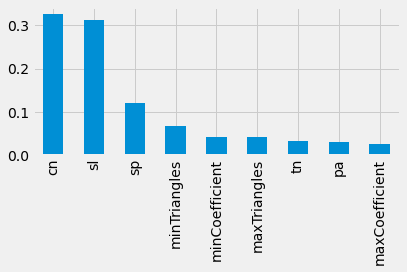

In [12]:
feature_importance(columns, classifier)